# **Data Modelling and Evaluation**

## Objectives
- Answer business requirement 2 : Whether a leave is powdery-mildew 

## Inputs
* inputs/cherry_dataset/cherry-leaves/test
- inputs/cherry_dataset/cherry-leaves/train
* inputs/cherry_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs 
- Images distribution plot in train, validation, and test set.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save the model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

# Import python packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# ML packages from TF
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


2023-08-25 16:32:58.933623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setting up directory to the parent directory

In [2]:
cwd = os.getcwd()
cwd

'/Users/rana/Documents/artificial_intelligence/PP5-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/Users/rana/Documents/artificial_intelligence/PP5-mildew-detection-in-cherry-leaves')
print('Parent directory set')

Parent directory set


In [4]:
current_dir = os.getcwd()
current_dir

'/Users/rana/Documents/artificial_intelligence/PP5-mildew-detection-in-cherry-leaves'

## Setting input directory

In [5]:
data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

## Setting Ouput directory


In [25]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Setting labels

In [12]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['powdery_mildew', 'healthy']


## Import set image shape


In [13]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50, 3)

# Checking number of images in train, test, and validate datasets

/var/folders/8k/tq0zypfs0nj94md0lwzwjpg80000gn/T/ipykernel_19833/2827683086.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/var/folders/8k/tq0zypfs0nj94md0lwzwjpg80000gn/T/ipykernel_19833/2827683086.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/var/folders/8k/tq0zypfs0nj94md0lwzwjpg80000gn/T/ipykernel_19833/2827683086.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/var/folders/8k/tq0zypfs0nj94md0lwzwjpg80000gn/T/ipykernel_19833/2827683086.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/var/folders/8k/tq0zypfs0nj94md0lwzwjpg80000gn/T/ipykernel_19833/282

* test - powdery_mildew: 422 images
* test - healthy: 422 images
* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images




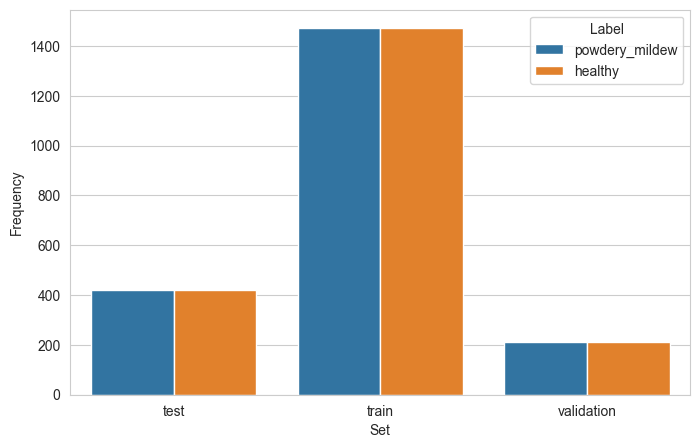

In [12]:
df = pd.DataFrame([])
for folder in ['test', 'train', 'validation']:
    for label in labels:
        df = df.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

The dataset contains relatively low number of images. For better accuracy we will augment images to increase the numbers

# Image augmentation

In [15]:
# Import imagedatagenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialising the function 

In [16]:
augmented_dataset = ImageDataGenerator(rotation_range=10,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augmenting training dataset

In [17]:
batch_size = 15 # running batch of 15 at a time
train_data_set = augmented_dataset.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_data_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augmentaing test dataset
As this is a test dataset, I am only standardisng the dataset and not providing other arguments

In [18]:
test_data_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_data_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augmenting validation dataset
As this is a test dataset, I am only standardisng the dataset and not providing other arguments

In [19]:
validation_data_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_data_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plotting augmented train images

(15, 50, 50, 3)


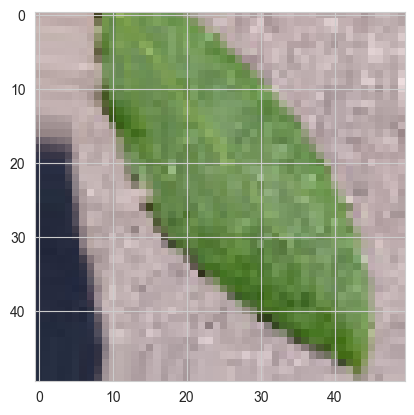

(15, 50, 50, 3)


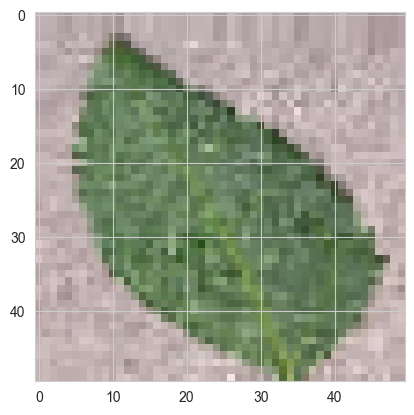

(15, 50, 50, 3)


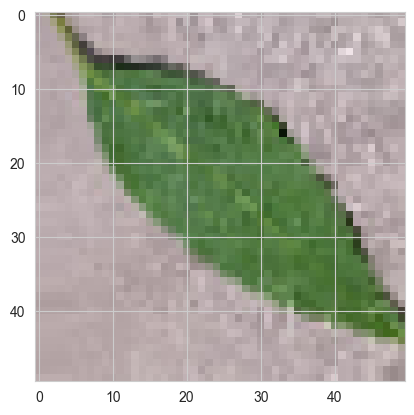

(15, 50, 50, 3)


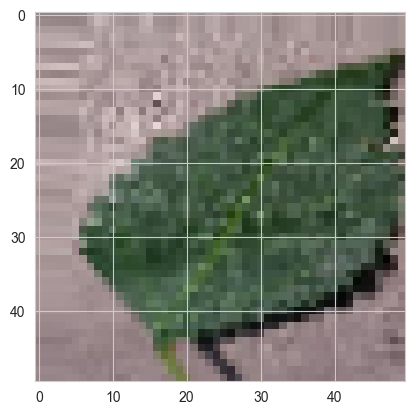

(15, 50, 50, 3)


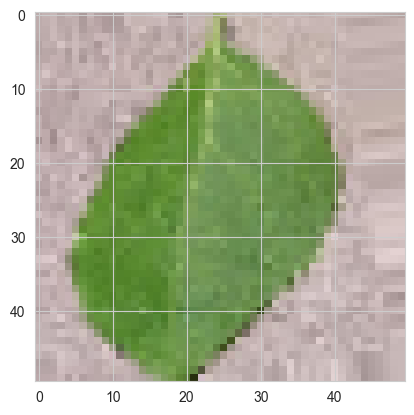

In [24]:
for _ in range(5):
    img, label = train_data_set.next()
    print(img.shape) #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

## Plotting augmented test images

(15, 50, 50, 3)


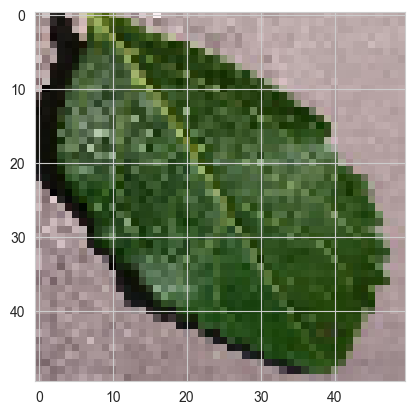

(15, 50, 50, 3)


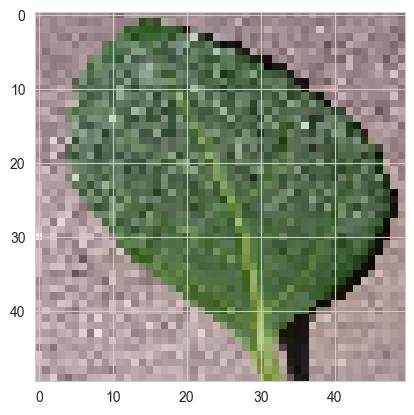

(15, 50, 50, 3)


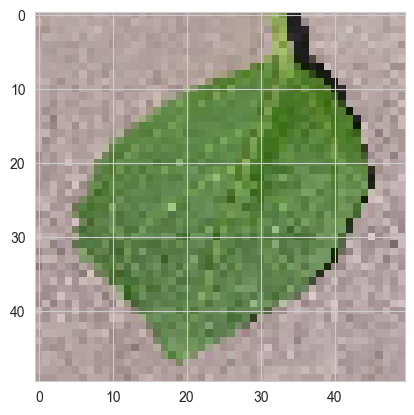

(15, 50, 50, 3)


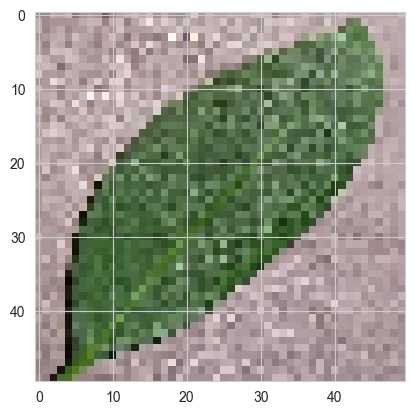

(15, 50, 50, 3)


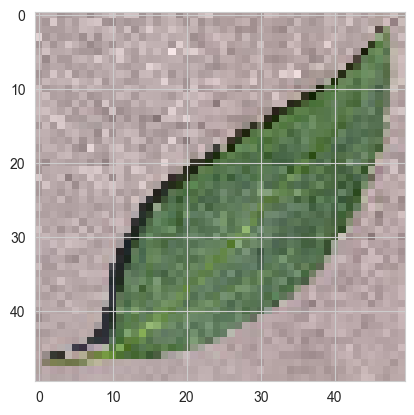

In [23]:
for _ in range(5):
    img, label = test_data_set.next()
    print(img.shape)  #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

## Plotting validation test images

(15, 50, 50, 3)


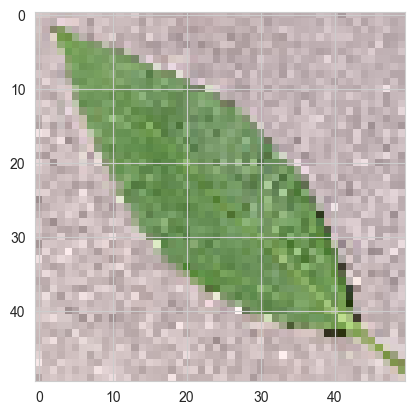

(15, 50, 50, 3)


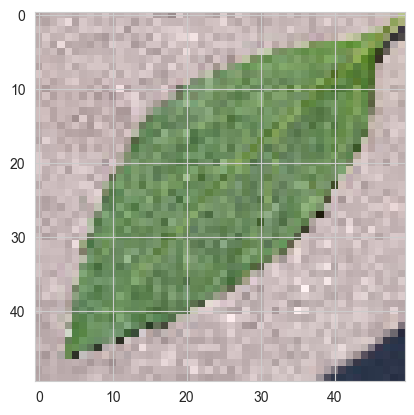

(15, 50, 50, 3)


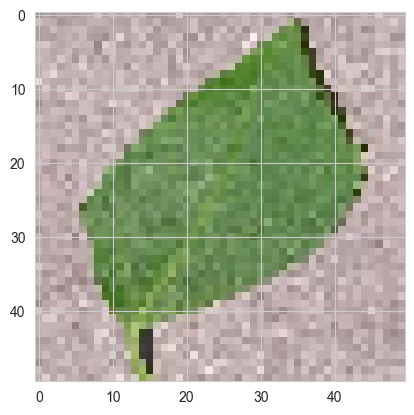

(15, 50, 50, 3)


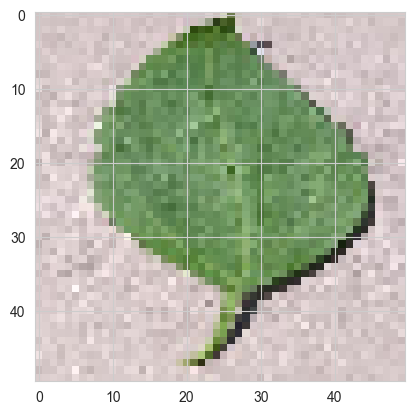

(15, 50, 50, 3)


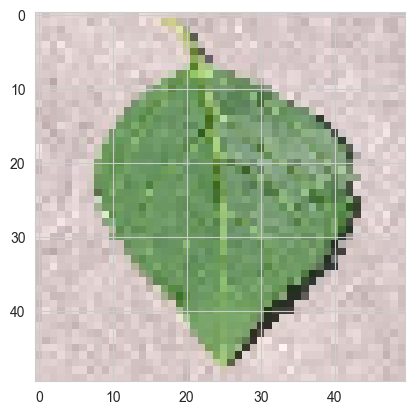

In [25]:
for _ in range(5):
    img, label = validation_data_set.next()
    print(img.shape)  #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

## Saving the indices

In [26]:
joblib.dump(value=train_data_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

# Machine Learning Model Creation 

## ML Model

- Model

In [8]:
def create_ml_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

- Model Summary

In [30]:
create_ml_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

- Callback - Early Stoppage
Define a call back functioin to monitor accuracy - 97% required by the client

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

## Fit the model for training

In [32]:
model = create_ml_model()
model.fit(train_data_set,
          epochs=20,
          steps_per_epoch=len(train_data_set.classes) // batch_size,
          validation_data=validation_data_set,
          callbacks=[callbacks],
          verbose=1
          )

Epoch 1/20
196/196 [==============================] - 12s 55ms/step - loss: 0.4145 - accuracy: 0.8030 - val_loss: 0.1176 - val_accuracy: 0.9619
Epoch 2/20
196/196 [==============================] - 9s 48ms/step - loss: 0.1947 - accuracy: 0.9245 - val_loss: 0.0588 - val_accuracy: 0.9857
Epoch 3/20
196/196 [==============================] - 10s 49ms/step - loss: 0.1308 - accuracy: 0.9549 - val_loss: 0.0241 - val_accuracy: 0.9952
Epoch 4/20
196/196 [==============================] - 9s 48ms/step - loss: 0.0922 - accuracy: 0.9689 - val_loss: 0.0324 - val_accuracy: 0.9881
Epoch 5/20
196/196 [==============================] - 9s 47ms/step - loss: 0.0711 - accuracy: 0.9764 - val_loss: 0.0174 - val_accuracy: 0.9952
Epoch 6/20
196/196 [==============================] - 10s 49ms/step - loss: 0.0695 - accuracy: 0.9792 - val_loss: 0.0234 - val_accuracy: 0.9905
Epoch 7/20
196/196 [==============================] - 10s 48ms/step - loss: 0.0452 - accuracy: 0.9857 - val_loss: 0.0193 - val_accuracy: 0.

## Saving the model

In [33]:
model.save('outputs/v1/mildew_detection_model.h5')


/Users/rana/Documents/artificial_intelligence/PP5-mildew-detection-in-cherry-leaves/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Performance Metrics

 - Learning Curve

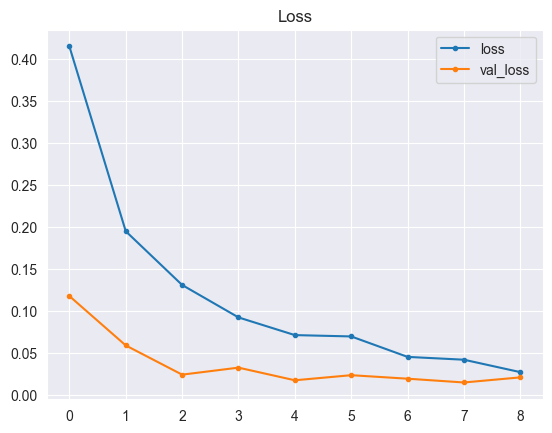

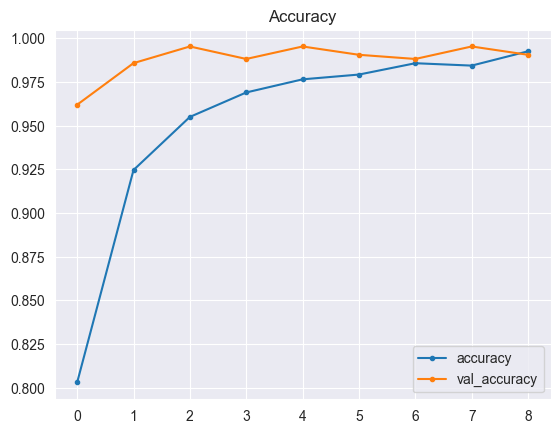

In [34]:
loss = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
loss[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
loss[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()